In [185]:
from numpy import dot
from numpy.linalg import norm
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [298]:
data = pd.read_excel('../Data/ИтоговыеДанные.xlsx')

In [306]:
# Группировка данных по клиентам и подсчет общего количества посещений и общего расхода
client_data = data.groupby('ID Клиента').agg({'МАГАЗИН': 'count', 'Сумма расходов': 'sum'})

# Создание вектора для каждого клиента
vectors = []
for client_id, row in client_data.iterrows():
    visits = row['МАГАЗИН']
    spending = row['Сумма расходов']
    vector = [visits, spending]
    vectors.append(vector)

# Преобразование векторов в DataFrame
cluster_vector = pd.DataFrame(vectors, columns=['Shop Attendance', 'Total Spendings'], index=client_data.index)

In [300]:
cluster_vector

,Shop Attendance,Total Spendings
ID Клиента,,
10157447,107,632039
10157454,1,163
10158439,27,635690
10158854,528,15423642
10159585,67,222196
...,...,...
11328050,186,8064333
11328121,13,1653598
11335636,1,884311


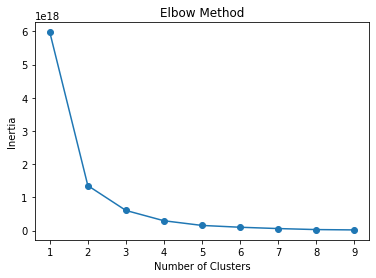

In [301]:
# Группировка данных по клиентам и подсчет общего количества посещений и общего расхода
client_data = cluster_vector.groupby('ID Клиента').agg({'Shop Attendance': 'count', 'Total Spendings': 'sum'})

# Создание вектора для каждого клиента
vectors = client_data[['Shop Attendance', 'Total Spendings']].values

# Преобразование векторов в DataFrame
cluster_vector = pd.DataFrame(vectors, columns=['Shop Attendance', 'Total Spendings'], index=client_data.index)

# Применение метода локтя для определения оптимального числа кластеров
# Задаем список чисел кластеров для проверки
cluster_range = range(1, 10)
inertia = []

# Выполняем KMeans для каждого значения числа кластеров
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(cluster_vector)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [366]:
total_spendings_mean = cluster_vector['Total Spendings'].mean()
shop_attendance_mean = cluster_vector['Shop Attendance'].mean()


def get_spendings(row):
    if row['Total Spendings'] <= total_spendings_mean:
        return 'Low'
    else:
        return 'High'

def get_attendance(row):
    if row['Shop Attendance'] <= shop_attendance_mean + 100:
        return 'Low'
    else:
        return 'High'
    
cluster_vector['SPENDINGS'] = cluster_vector.apply(get_spendings, axis=1)
cluster_vector['ATTENDANCE'] = cluster_vector.apply(get_attendance, axis=1)

In [367]:
cluster_vector

,Shop Attendance,Total Spendings,SPENDINGS,ATTENDANCE
ID Клиента,,,,
10157447,107,632039,Low,Low
10157454,1,163,Low,Low
10158439,27,635690,Low,Low
10158854,528,15423642,High,High
10159585,67,222196,Low,Low
...,...,...,...,...
11328050,186,8064333,Low,Low
11328121,13,1653598,Low,Low
11335636,1,884311,Low,Low


In [368]:
# Создание списков с ID клиентов с высоким и низким показателем INCOME
high_spendings = cluster_vector[cluster_vector['SPENDINGS'] == 'High'].index.tolist()
low_spendings = cluster_vector[cluster_vector['SPENDINGS'] == 'Low'].index.tolist()

# Создание списков с ID клиентов с высоким и низким показателем ATTENDANCE
high_attendance = cluster_vector[cluster_vector['ATTENDANCE'] == 'High'].index.tolist()
low_attendance = cluster_vector[cluster_vector['ATTENDANCE'] == 'Low'].index.tolist()


In [369]:
def find_samplers_(group):
    for i in group:
        # Winsorize the spending data
        spending = data[data['ID Клиента'] == i]['Сумма расходов']
        winsorized_spending = np.clip(spending, spending.quantile(0.05), spending.quantile(0.95))
        
        discount = list(data[data['ID Клиента'] == i]['Предоставленная скидка'].unique())[0]
        n_shops = cluster_vector.loc[i]['Shop Attendance']
        
        if winsorized_spending.mean() > 50000 and discount > 15 and n_shops >= 10:
            print(i)

In [370]:
find_samplers(high_spendings)

10574034
11018820
11127430
11259771
11260095


In [371]:
find_samplers(high_attendance)

11018820
11127430
11259771
11260095


In [384]:
data[data['ID Клиента'] == 11018820.0]

,Unnamed: 0,Торговый день,ID Клиента,Регион проживания,МАГАЗИН,"Тип карточки (B-VISA, S-MASTERCARD или МИР)",Сумма расходов,Предоставленная скидка,Возраст клиента,Цена без скидки
297,297,2020-07-08,11018820,г.Москва,Алкогольный магазин,S,94250,21,21,119303
311,311,2020-07-13,11018820,г.Москва,Не определено,B,50010,21,21,63303
317,317,2020-07-14,11018820,г.Москва,Не определено,B,31780,21,21,40227
318,318,2020-07-14,11018820,г.Москва,"Бар ""Коктейль""",B,35240,21,21,44607
368,368,2020-07-24,11018820,г.Москва,Не определено,S,67950,21,21,86012
...,...,...,...,...,...,...,...,...,...,...
41847,41880,2022-02-25,11018820,г.Москва,"Бар ""Коктейль""",S,49267,21,21,62363
42604,42637,2022-09-02,11018820,г.Москва,"Бар ""Коктейль""",B,164,21,21,207
42631,42664,2022-09-07,11018820,г.Москва,"Бар ""Коктейль""",B,56,21,21,70
42709,42742,2022-09-20,11018820,г.Москва,"Бар ""Коктейль""",B,116,21,21,146
